# This is just a notebook to visualise 1kHz filtered raw data

## Setup everything

### Import packages

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

from ephyviewer import mkQApp, MainViewer, TraceViewer, TimeFreqViewer, InMemoryAnalogSignalSource, EventList
from ephyviewer import AnalogSignalSourceWithScatter, SpikeInterfaceRecordingSource, InMemoryEventSource

# add the Contrib dir that contains all tools developped by MB : mbTools.py
#sys.path.append(os.path.join(os.path.dirname(sys.path[0]),'python'))
#print(os.path.join(os.path.dirname(sys.path[0]),'python'))
from mbTools import mbTools

import configparser
import json
import ast


### Import local config, create it if inexistant
All user-specific configuration (projects, defautl path to files...) are stored in a file named localConfig.ini in the python subfolder of AudreyHayLab repo. It is ignored by git so that it remains truely local. If the file does not exist at beginning, it is created with default values that can be modified at whishes.

In [2]:
config = mbTools.localConf()
rawDataPath = config['DATA']['path']
print(f'All raw data are expected to be found in the folder: {rawDataPath}')
analysisPath = config['ANALYSIS']['path']
print(f'All analysis will be saved in the folder: {analysisPath}')
config.printAll()

Local config file loaded from localConfig.ini
All raw data are expected to be found in the folder: C:\Users\Manip1
All analysis will be saved in the folder: C:\Users\Manip1\Analysis
DATA
[('path', 'C:\\Users\\Manip1')]
ANALYSIS
[('path', 'C:\\Users\\Manip1\\Analysis'),
 ('projecttype', '0'),
 ('animalid', '0'),
 ('projectid', 'AProject'),
 ('subprojectid', 'OneOfItsSubProject'),
 ('conditionid', 'control'),
 ('recordingid', '0'),
 ('suffix', '')]
AProject.OneOfItsSubProject
[('design', '0'),
 ('nanimal', '6'),
 ('conditions', "['control']"),
 ('nrecordings', '1')]


## Choose experiment
Select the experiment to display. If the experiment was already analyzed, a saved_dictionary.pkl was created and contains all necessary variables. Select this file. Otherwise select the raw data recording file.
>**If you have a file with channel mapping somewhere**, we should make sure it is properly translated into a dict.pkl

In [3]:
currentFile = None
%store -r currentFile
print(currentFile)
try:
    theExpe = mbTools.expeConfigDict(currentFile)
except Exception as error:
    print(error)
    theExpe = mbTools.expeConfigDict()

C:\Users\Manip1\Analysis\AProject\OneOfItsSubProject\control\0\saved_dictionary.pkl
Local config file loaded from localConfig.ini
the file is C:\Users\Manip1\Analysis\AProject\OneOfItsSubProject\control\0\saved_dictionary.pkl


FileChooser(path='C:\Users\Manip1\Analysis\AProject\OneOfItsSubProject\control\0', filename='saved_dictionary.…

### Possibility to change raw data path 
if for some reason the path to the raw data is wrong, you can update it here

In [ ]:
theExpe.rawDataSelector()

## Load Data

### Map the whole data into memory

In [4]:
if False:
    dpath = None #  '//10.69.168.1/crnldata/waking/audrey_hay/NPX/NPX4_claustrum/Expe_2024-07-18_12-00-43/'
    # %store dpath
    %store -r dpath
    print(dpath)
    theExpe.rawDataPath = dpath
print(theExpe.rawDataPath)
thedata = mbTools.experiment(theExpe)

\\10.69.168.1\crnldata\waking\audrey_hay\NPX\NPX1\Reuniens\Expe_2024-07-20_12-45-29\


FileChooser(path='\\10.69.168.1\crnldata\waking\audrey_hay\NPX\NPX1\Reuniens\Expe_2024-07-20_12-45-29', filena…

In [5]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
thedata.analyseExpe_findData()

\\10.69.168.1\crnldata\waking\audrey_hay\NPX\NPX1\Reuniens\Expe_2024-07-20_12-45-29
found some .bin files
data recorded with Bonsai
importing \\10.69.168.1\crnldata\waking\audrey_hay\NPX\NPX1\Reuniens\Expe_2024-07-20_12-45-29\OE_32ch_data_2024-07-20T12_45_29.bin
applying offset
converting to int16
IntanLFP file loaded, with 32 channels and 106671104 datapoint
found some NPX files
the calculated sampling rate is 30070.243213822876 Hz
launch start would be 2024-07-20 12:45:29.896598+02:00
the interval to first clock is 0.041224
the first timestamp for 10306075 samples, corresponding to 0.041224 s, would be 2024-07-20 12:45:29.937822+02:00
there are 161553312 timestamps
the calculated sampling rate is 30070.243213822876 Hz
launch start would be 2024-07-20 12:45:29.896598+02:00
the interval to first clock is 0.041224
the first timestamp for 10306075 samples, corresponding to 0.041224 s, would be 2024-07-20 12:45:29.937822+02:00
there are 161553312 timestamps


### Extract submatrix of interest

In [6]:
#initiate combined and channelLabels
combined =  {}
channelLabels = {}
sample_rates = {}
t_start = {}
#t_end = 300 #seconds

In [7]:
expeConfigFN=os.path.sep.join([theExpe.rawDataPath,'expeConfig.ini'])
parser = configparser.ConfigParser()
parser.read(expeConfigFN)

if os.path.isfile(expeConfigFN):
    print('mapping exists so loading it')
    thedata.data['OE_LFP'].channelsMap = ast.literal_eval(parser['OE_LFP']['channelsMap'])
    thedata.data['OE_LFP'].start=ast.literal_eval(parser['OE_LFP']['start'])
    thedata.data['OE_LFP'].sampling_rate=ast.literal_eval(parser['OE_LFP']['freq'])
else:
    print("mapping doesn't exist so generating it")
    thedata.data['OE_LFP'].channelsMap = dict( \
            M1 = [dict(canal = 17, status=1),
                dict(canal = 16, status=2)],
        )

    parser['OE_LFP'] = {'channelsMap': thedata.data['OE_LFP'].channelsMap}


    artefacts=[55.2, 88.74, 90.6, 121.18, 123, 188, 268, 2065, 3036, 3754, 3590]
    parser['OE_LFP']['artefacts']=str(artefacts)


    parser['OE_LFP']['start']=str(52.7137)

    with open(expeConfigFN, 'w') as configfile:
        parser.write(configfile)

print("the mapping:", thedata.data['OE_LFP'].channelsMap)
print("the offset: ", thedata.data['OE_LFP'].start)
print("the sampling rate: ", thedata.data['OE_LFP'].sampling_rate)

thedata.data['OE_LFP'].reAlignTimes()


mapping exists so loading it
the mapping: {'M1': [{'canal': 17, 'status': 1}, {'canal': 16, 'status': 2}]}
the offset:  51.44846048
the sampling rate:  20046.76684681


### Extract submatrix of interest

In [8]:
#LFP
if 'OE_LFP' in thedata.data:
    sample_rates['LFP'] = thedata.data['OE_LFP'].sampling_rate #20000
    t_start['LFP'] = thedata.data['OE_LFP'].start
    combined['LFP'] = thedata.data['OE_LFP'].combineStructures(['M1'])
    channelLabels['LFP'] = thedata.data['OE_LFP'].channelLabels[:]
    print("LFP data combined")
else:
    print("no LFP data to combine")

M1 -> [{'canal': 17, 'status': 1}, {'canal': 16, 'status': 2}]
Getting differential signal of channel 16 - channel 17 for M1
LFP data combined


In [9]:
#NPX
if 'NPX' in thedata.data:
    sample_rates['NPX'] = thedata.data['NPX'].sampling_rate #30000
    t_start['NPX'] = thedata.data['NPX'].start
    combined['NPX'] = thedata.data['NPX'].signal['spike']
    channelLabels['NPX'] = thedata.data['NPX'].channelLabels
    print("NPX data combined")
else:
    print("no NPX data to combine")

NPX data combined


In [10]:
def resetAlign():
    offset=0
    freq=20000
    print(f'freq is {freq}')

    thedata.data['OE_LFP'].start = offset
    thedata.data['OE_LFP'].sampling_rate = freq

    sample_rates['LFP'] = thedata.data['OE_LFP'].sampling_rate #20000
    t_start['LFP'] = thedata.data['OE_LFP'].start

    thedata.data['OE_LFP'].times=np.linspace(0,thedata.data['OE_LFP'].signal.shape[0]/freq,thedata.data['OE_LFP'].signal.shape[0])

    print(thedata.data['OE_LFP'].times)
    
resetAlign()

freq is 20000
[0.00000000e+00 5.00000005e-05 1.00000001e-04 ... 5.33355510e+03
 5.33355515e+03 5.33355520e+03]


freq is 20000
[0.00000000e+00 5.00000005e-05 1.00000001e-04 ... 5.33355510e+03
 5.33355515e+03 5.33355520e+03]
214.00000200616657
4280000
[4.12243000e-02 4.12575560e-02 4.12908080e-02 ... 5.37257206e+03
 5.37257210e+03 5.37257213e+03]
6433771


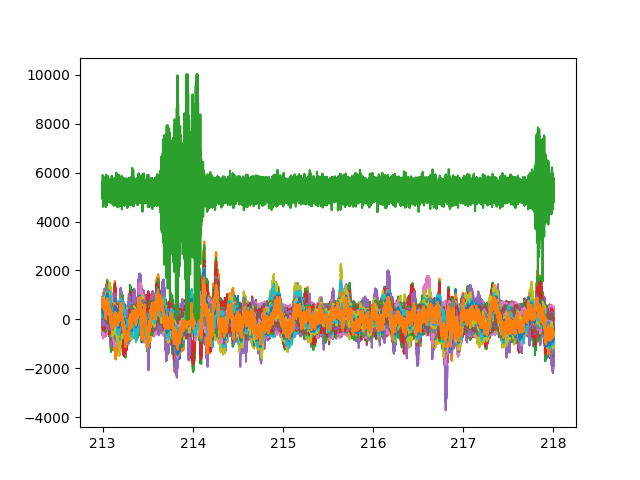

In [11]:
%matplotlib widget

def FindAlign(t, pre=1, post=4):
    plt.close()

    resetAlign()
    offset=0#51.5146186247

    idx=mbTools.find_nearest(thedata.data['OE_LFP'].times,t)
    print(thedata.data['OE_LFP'].times[idx])
    print(idx)

    x=thedata.data['OE_LFP'].times[idx-int(pre*thedata.data['OE_LFP'].sampling_rate):idx+int(post*thedata.data['OE_LFP'].sampling_rate)]
    y=thedata.data['OE_LFP'].signal[idx-int(pre*thedata.data['OE_LFP'].sampling_rate):idx+int(post*thedata.data['OE_LFP'].sampling_rate),:]

    print(thedata.data['NPX'].times)
    idx2=mbTools.find_nearest(thedata.data['NPX'].times,t)
    print(idx2)
    x2=thedata.data['NPX'].times[idx2-int(pre*thedata.data['NPX'].sampling_rate):idx2+int(post*thedata.data['NPX'].sampling_rate)]
    y2=thedata.data['NPX'].signal['spike'].get_traces(start_frame=idx2-int(pre*thedata.data['NPX'].sampling_rate), end_frame=idx2+int(post*thedata.data['NPX'].sampling_rate), return_scaled=False)

    plt.plot(x, y,'-')
    plt.plot(x2, np.transpose(y2[:,0])*10,'-')
    plt.show()

FindAlign(214)# 214 162

 #88.74    121.17      artefacts=[55.2, 88.74, 90.6, 121.18, 123, 188, 268, 2065, 3036, 3754, 3590]


freq is 20000
[0.00000000e+00 5.00000005e-05 1.00000001e-04 ... 5.33355510e+03
 5.33355515e+03 5.33355520e+03]
112877
3255252
105455237
[112877, 3255252, 105455237]
[[20046.76684681]] [51.44846048]
0.9999999999999999


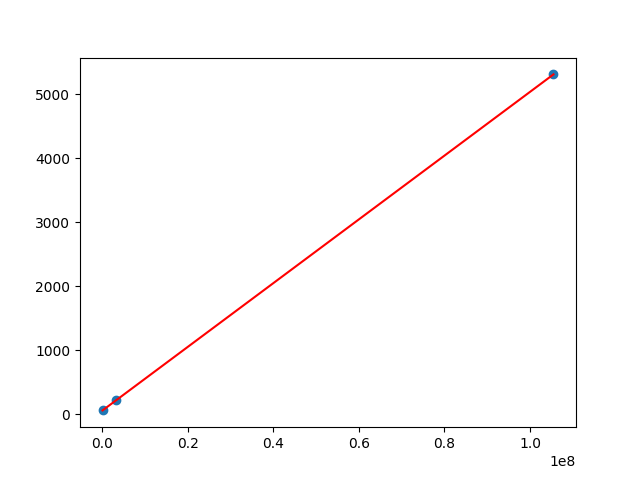

MAE: 2.4364454925300077e-05
MSE: 2.9405278495203926e-05


In [52]:
#artefacts=[55, 62, 103, 164, 214, 5184, 5312]
#lfp: 114, 162, 183

NPX=[ 88.747912, 121.184201, 172.07995, 268.4151039, 3590.1866616 ] #55.498705,
timesreset=[37.324650495, 69.8368, 120.8515516, 217.4120529, 3546.950397] #3.9655,


NPX=[ 57.079179468, 213.831317136, 5311.909552668] #214.083826084  #459096    
timesreset=[ 5.64385005,  162.7626014, 5272.761899430087]#163.0008 #6385152

resetAlign()
LFPpoint=[]
for t in timesreset:
    if t is not np.nan:
        p=mbTools.find_nearest(thedata.data['OE_LFP'].times,t)
    else:
        p=np.nan
    print(p)
    LFPpoint.append(p)
print(LFPpoint)
LFPpoint=np.array(LFPpoint).reshape(-1, 1)
NPX=np.array(NPX).reshape(-1, 1)

from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(LFPpoint,NPX)
a = reg.coef_
b = reg.intercept_
print(1/a, b)

print(reg.score(LFPpoint, NPX)) 


plt.close()
y_pred = reg.predict(LFPpoint) 
plt.plot(LFPpoint,y_pred,color='r')
plt.scatter(LFPpoint,NPX)
plt.show()

from sklearn.metrics import mean_absolute_error,root_mean_squared_error 
  
mae = mean_absolute_error(y_true=NPX,y_pred=y_pred) 
#squared True returns MSE value, False returns RMSE value. 
mse = root_mean_squared_error(y_true=NPX,y_pred=y_pred) #default=True 


print("MAE:",mae) 
print("MSE:",mse) 

#20047.170454611958
#51.51461862479928
#51.51461862479937

#51.5146156977

In [13]:
def realign(offset=0, freq=2000):
    print(thedata.data['NPX'].times[-1])
    print(thedata.data['OE_LFP'].signal.shape)
    dt=thedata.data['NPX'].times[-1]-offset
    print(f'freq is {freq}')

    thedata.data['OE_LFP'].start = offset
    thedata.data['OE_LFP'].sampling_rate = freq

    sample_rates['LFP'] = thedata.data['OE_LFP'].sampling_rate #20000
    t_start['LFP'] = thedata.data['OE_LFP'].start

    #thedata.data['OE_LFP'].times2=np.arange(t_start['LFP'],thedata.data['NPX'].times[-1],1/freq2)
    #thedata.data['OE_LFP'].times=np.linspace(t_start['LFP'],thedata.data['NPX'].times[-1]+endoffset/freq,thedata.data['OE_LFP'].signal.shape[0])
    #thedata.data['OE_LFP'].times=np.linspace(t_start['LFP'],thedata.data['OE_LFP'].signal.shape[0]/freq+t_start['LFP']+endoffset/freq,thedata.data['OE_LFP'].signal.shape[0])
    thedata.data['OE_LFP'].times=np.linspace(0,thedata.data['OE_LFP'].signal.shape[0]/freq,thedata.data['OE_LFP'].signal.shape[0])+offset

    print(thedata.data['OE_LFP'].times)
    print(thedata.data['NPX'].times)

realign(51.510352065518585)

5372.572129728
(106671104, 32)
freq is 2000
[5.15103521e+01 5.15108521e+01 5.15113521e+01 ... 5.33870614e+04
 5.33870619e+04 5.33870624e+04]
[4.12243000e-02 4.12575560e-02 4.12908080e-02 ... 5.37257206e+03
 5.37257210e+03 5.37257213e+03]


55.00000578461223
71197
[4.12243000e-02 4.12575560e-02 4.12908080e-02 ... 5.37257206e+03
 5.37257210e+03 5.37257213e+03]
1652612


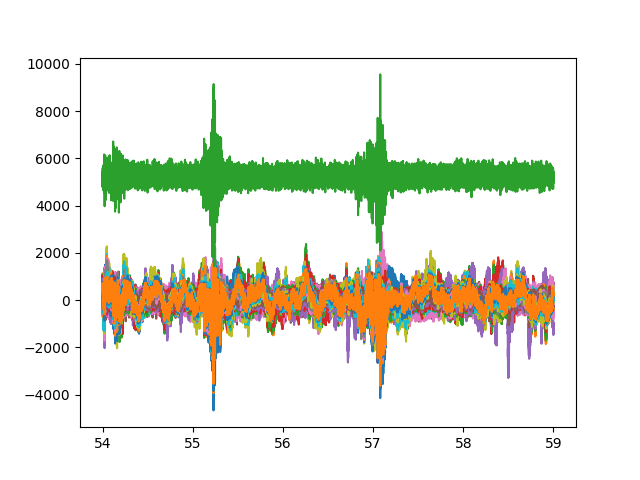

5260.519626494362


5272.761899430087

In [10]:
%matplotlib widget

def superCleanPlot(t, pre=1, post=4):
    plt.close()

    #offset=51.51#51.4576900#t_start['LFP']#52.6734#52.68
    # perfect align manual offset=51.5146156977
    #offset=51.52262754

    idx=mbTools.find_nearest(thedata.data['OE_LFP'].times,t)
    print(thedata.data['OE_LFP'].times[idx])
    print(idx)

    x=thedata.data['OE_LFP'].times[idx-int(pre*thedata.data['OE_LFP'].sampling_rate):idx+int(post*thedata.data['OE_LFP'].sampling_rate)]
    y=thedata.data['OE_LFP'].signal[idx-int(pre*thedata.data['OE_LFP'].sampling_rate):idx+int(post*thedata.data['OE_LFP'].sampling_rate),:]

    print(thedata.data['NPX'].times)
    idx2=mbTools.find_nearest(thedata.data['NPX'].times,t)
    print(idx2)
    x2=thedata.data['NPX'].times[idx2-int(pre*thedata.data['NPX'].sampling_rate):idx2+int(post*thedata.data['NPX'].sampling_rate)]
    y2=thedata.data['NPX'].signal['spike'].get_traces(start_frame=idx2-int(pre*thedata.data['NPX'].sampling_rate), end_frame=idx2+int(post*thedata.data['NPX'].sampling_rate), return_scaled=False)

    plt.plot(x, y,'-')
    plt.plot(x2, np.transpose(y2[:,0])*10,'-')
    plt.show()

#NPX=[55.498705, 88.747912, 121.184201, 172.07995, 268.4151039, 3590 ]
#h b b b h
# LFP d d d d g
offset=51.44846048#51.44849852  #51.51029122
freq= 20046.76684681#20046.77605517 #20046.76315209

#[[20046.76684681]] [51.44846048]


51.448434327409814
20046.725110375297
#[[20046.77605517]] [51.44849852]


#realign(offset=offset, freq=freq)
#resetAlign()
superCleanPlot(55) #5273
print(5311.967649928-51.44802343363881)
#artefacts=[55, 62, 103, 164, 214 , 5184, 5312]
#lfp: 114, 162, 183
5311.909552668
5272.761899430087

ok, fitting is good with plenty of artefacts to realign, now let's try to find a function that depends on timestamps, number of points theoric frequencies...
first; let's try to see how many samples are recorded by npx at the end of recording compared to LFP

In [ ]:
sizeLFP=thedata.data['OE_LFP'].signal.shape[0]
print(sizeLFP)
offset=51.51029122
freq= 20046.76315209

realign(offset=offset, freq=freq)
lastT=thedata.data['NPX'].times[-1]
idx=mbTools.find_nearest(thedata.data['OE_LFP'].times,lastT)
print(thedata.data['OE_LFP'].times[idx])
print(sizeLFP-idx)
print(idx%1024)

the recordings seem to end together, it might be a coincidence that recording stops so near a multiple of 1024 => should make sure on another experiment.
Now, let's see if we can use the end of recordin and a single artefact to realign everything

freq is 20000
[0.00000000e+00 5.00000005e-05 1.00000001e-04 ... 5.33355510e+03
 5.33355515e+03 5.33355520e+03]
106671104
112877
5.643850052908893
dn measured with lfp : 106558226
1715133
dt measured with npx : 5315.49295026
51.435329418
[4.12243000e-02 4.12575560e-02 4.12908080e-02 ... 5.37257206e+03
 5.37257210e+03 5.37257213e+03]
[0.00000000e+00 5.00000005e-05 1.00000001e-04 ... 5.33355510e+03
 5.33355515e+03 5.33355520e+03]
[  39.01692973   39.01697973   39.01702973 ... 5372.57202973 5372.57207973
 5372.57212973]
dt measured with lfp : 5315.49295026
20046.725110375297
5372.572129728
(106671104, 32)
freq is 20046.725110375297
[0.00000000e+00 4.98834600e-05 9.97669199e-05 ... 5.32112360e+03
 5.32112365e+03 5.32112370e+03]
[4.12243000e-02 4.12575560e-02 4.12908080e-02 ... 5.37257206e+03
 5.37257210e+03 5.37257213e+03]
times npx [4.12243000e-02 4.12575560e-02 4.12908080e-02 ... 5.37257206e+03
 5.37257210e+03 5.37257213e+03]
times lfp [0.00000000e+00 4.98834600e-05 9.97669199e-05 ... 5.3

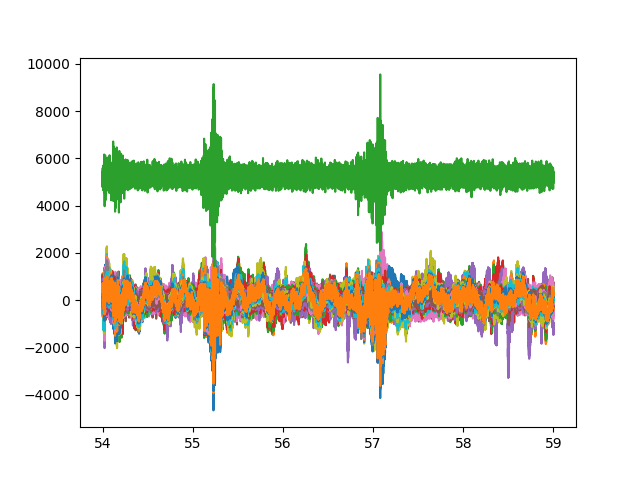

In [26]:
#let's try with first artefact
#NPX=[ 88.747912, 121.184201, 172.07995, 268.4151039, 3590.1866616 ] #55.498705,
#timesreset=[37.324650495, 69.8368, 120.8515516, 217.4120529, 3546.950397] #3.9655,
#offset=51.51029122
#freq= 20046.76315209
resetAlign() #so that lfpT is correct
endoffset=1
npxT= 57.079179468   #213.831317136 #214.083826084  #459096    
lfpT= 5.64385005  #162.7626014 #163.0008 #6385152

idx=mbTools.find_nearest(thedata.data['OE_LFP'].times,lfpT)
print(thedata.data['OE_LFP'].signal.shape[0])
print(idx)
print(thedata.data['OE_LFP'].times[idx])
dn=thedata.data['OE_LFP'].signal.shape[0]-idx-endoffset
print(f"dn measured with lfp : {dn}")



iNPX=mbTools.find_nearest(thedata.data['NPX'].times,npxT)
print(iNPX)

print(f"dt measured with npx : {thedata.data['NPX'].times[-1]-npxT}")


npxdt=thedata.data['NPX'].times[-1]-npxT


print(npxT-lfpT)

print(thedata.data['NPX'].times)
print(thedata.data['OE_LFP'].times)
thedata.data['OE_LFP'].times+=(thedata.data['NPX'].times[-1]-thedata.data['OE_LFP'].times[-1])
print(thedata.data['OE_LFP'].times)

dt=thedata.data['OE_LFP'].times[-1]-npxT
print(f"dt measured with lfp : {dt}")




freqC=dn/dt
print(freqC)




realign(offset=0, freq=freqC)
print("times npx", thedata.data['NPX'].times)
print("times lfp", thedata.data['OE_LFP'].times)
offsetC=-(thedata.data['OE_LFP'].times[-1]-thedata.data['NPX'].times[-1])
print("calculated offset", offsetC)

realign(offset=offsetC, freq=freqC)

superCleanPlot(55)



In [ ]:
#produit en croix
#x=s+n/f

#x2-x1


#trouver 2 artéfacts et prendre: t, le début artéfact NPX ; n le point du début LFP
t2= 3754.42818#121.184201
x2= 3754.45765#120.184803)#29121.184418)
print(n2)#1396736
n2=mbTools.find_nearest(thedata.data['OE_LFP'].times,x2)
print(n2)#746493
print(thedata.data['OE_LFP'].times[n2])
t1=88.747912
x1=88.748234#7478455)
print(n1)
n1=mbTools.find_nearest(thedata.data['OE_LFP'].times,x1)
print(n1)

#x1=88.747912
#s1= 51.51
#x2=121.1842
#s2=51.50974

#n1=mbTools.find_nearest(thedata.data['OE_LFP'].times2,x1)
#n2=mbTools.find_nearest(thedata.data['OE_LFP'].times2,x2)
dn=(n2-n1)
print(dn)

dt=(t2-t1)
print(dt)
freq=(dn/dt)
print(freq)

start=t1-n1/freq
print(start)
start2=t2-n2/freq
print(start2)



Les timesstamps de LFP ne sont pas parfaitement linéaires. C'est d'ailleurs ce que semble aussi indiquer les fréquences réelles instantanées. La nouvelle stratégie va donc être d'utiliser les timestamps openEphys et de réaligner NPX par la fin en ajustant la freqclock

In [ ]:
from mbTools import mbTools
thedata.data['OE_LFP'].loadTimeStamps()
print(thedata.data['OE_LFP'].times)
print(thedata.data['NPX'].times)
print(thedata.data['NPX'].times[-1]-thedata.data['OE_LFP'].times[-1])

In [ ]:
#artefacts=[55.2 (last tall positive peak),                     (spike)
# 88.74 (very begining of first isolated positive peak), 
# 90.6 (very begining of last tall positiv peak), 
# 121.18 (begining of last positive peak of the serie of 3),
# 268 (very begining of huge artefact),                            artefact!!
# 2065, 3036, 3754, 3590]
NPX=[55.498705, 88.747912, 121.184201, 268.4151039, 3590.186994 ]#186656, 90.61487609
timesstamped=[3.970066,37.29871343,69.816448,217.4129595, 3546.950396 ]#,39.1802152
#timesreset=[3.9655,37.324650495,39.196,69.8368,217.4120529]

timesstamped=np.array(timesstamped).reshape(-1, 1)
NPX=np.array(NPX).reshape(-1, 1)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

reg = LinearRegression()
reg.fit(NPX,timesstamped)
a = reg.coef_
b = reg.intercept_
print(1/a, b)

y_pred = reg.predict(NPX) 


plt.close()
plt.plot(NPX,y_pred,color='r')
plt.scatter(NPX,timesstamped)
plt.show()


print(reg.score(NPX, timesstamped)) 


from sklearn.metrics import mean_absolute_error,root_mean_squared_error 
  
mae = mean_absolute_error(y_true=NPX,y_pred=y_pred) 
#squared True returns MSE value, False returns RMSE value. 
mse = root_mean_squared_error(y_true=NPX,y_pred=y_pred) #default=True 


print("MAE:",mae) 
print("MSE:",mse)

In [ ]:
%matplotlib widget

def superCleanPlotTS(t, pre=1, post=4):
    plt.close()

    #offset=51.51#51.4576900#t_start['LFP']#52.6734#52.68
    # perfect align manual offset=51.5146156977
    #offset=51.52262754
    offset=51.64998816
    expandfactor=0.99766175
               
    #realign(offset=offset)
    idx=mbTools.find_nearest(thedata.data['OE_LFP'].times,t-offset)
    print(thedata.data['OE_LFP'].times[idx])
    print(idx)

    x=thedata.data['OE_LFP'].times[idx-int(pre*thedata.data['OE_LFP'].sampling_rate):idx+int(post*thedata.data['OE_LFP'].sampling_rate)]
    y=thedata.data['OE_LFP'].signal[idx-int(pre*thedata.data['OE_LFP'].sampling_rate):idx+int(post*thedata.data['OE_LFP'].sampling_rate),:]

    print(thedata.data['NPX'].times)
    times=thedata.data['NPX'].times/expandfactor
    idx2=mbTools.find_nearest(times,t)
    print(idx2)
    x2=times[idx2-int(pre*thedata.data['NPX'].sampling_rate):idx2+int(post*thedata.data['NPX'].sampling_rate)]
    y2=thedata.data['NPX'].signal['spike'].get_traces(start_frame=idx2-int(pre*thedata.data['NPX'].sampling_rate), end_frame=idx2+int(post*thedata.data['NPX'].sampling_rate), return_scaled=False)

    plt.plot(x+offset, y,'-')
    plt.plot(x2, np.transpose(y2[:,0])*10,'-')
    plt.show()

#superCleanPlot(55.6, pre=0.2, post=0.5)
superCleanPlotTS(3599)
print(0.184197-0.184452)
#superCleanPlot(268.4151039, pre=0.01, post=0.03)   #88.74    121.17      artefacts=[55.2, 88.74, 90.6, 121.18, 123, 188, 268, 2065, 3036, 3754, 3590]
#superCleanPlot(77.65, pre=0.2, post=0.2)

In [ ]:
0.9999999800851352
0.9999999999497421
superCleanPlotTS(268)

### Load extra stuff

In [ ]:
from mbTools import mbTools
All_Spindle, M1 = thedata.data['OE_LFP'].loadSpindles(relativePath='../LFP', structure = "M1")
combined['LFP_DS']=M1[:,np.newaxis]
channelLabels['LFP_DS'] = ['M1_DS']
freqInitTheoric=20000
freqDS=1000
realignFactor=freqInitTheoric/sample_rates['LFP']
sample_rates['LFP_DS']=freqDS*realignFactor
t_start['LFP_DS']=t_start['LFP']
print(realignFactor)

In [33]:

M1_i=thedata.data['OE_LFP'].combineStructures(['M1'])[:,0]
M1_1=thedata.data['OE_LFP'].signal[:,16]
M1_2=thedata.data['OE_LFP'].signal[:,17]
M1_iL=thedata.data['OE_LFP'].channelLabels[:]
print(M1_1.shape)
print(M1_2.shape)
print(M1_i.shape)
combined['LFP'] = np.stack([M1_i,M1_1, M1_2], axis = 1) #cortex, filt_cortex, proj_cortexC, proj_cortex
print(combined['LFP'].shape)
channelLabels['LFP'] = ['M1_iL','ch16','ch17']



M1 -> [{'canal': 17, 'status': 1}, {'canal': 16, 'status': 2}]
Getting differential signal of channel 16 - channel 17 for M1
(106671104,)
(106671104,)
(106671104,)
(106671104, 3)


## Display

In [34]:
%gui qt
app = mkQApp()


try:
    TTL = Timestamps

    #create 2 familly scatters from theses 2 indexes
    scatter_indexes = {0: TTL, 1: TTL}
    #and asign them to some channels each
    scatter_channels = {0: [0, 12], 1: [0, 1]}
    #source = AnalogSignalSourceWithScatter(combined, sample_rate, t_start, scatter_indexes, scatter_channels)
except Exception:
    pass

#Create the main window that can contain several viewers
win = MainViewer(debug=True)

if 'LFP' in combined:
    print(sample_rates['LFP'], t_start['LFP'])
    source = InMemoryAnalogSignalSource(combined['LFP'], sample_rates['LFP'], t_start['LFP'], channel_names=channelLabels['LFP'])
    view1 = TraceViewer(source=source, name = 'LFP')

    #Parameters can be set in script
    view1.params['display_labels'] = True
    view1.params['scale_mode'] = 'same_for_all'
    view1.auto_scale()

    cmap = matplotlib.colormaps["hsv"]#Wistia"]
    nCh = len(view1.by_channel_params.children())
    for ch in range(nCh):
        #view1.by_channel_params[f'ch{ch}', 'gain'] = 0.00002
        #view1.by_channel_params[f'ch{ch}', 'offset'] = 0.1
        view1.by_channel_params[f'ch{ch}', 'color'] = matplotlib.colors.to_hex(cmap(ch/nCh), keep_alpha=False)
        pass

    #create a time freq viewer conencted to the same source
    view2 = TimeFreqViewer(source=source, name='tfr')
    view2.params['show_axis'] = False
    view2.params['timefreq', 'deltafreq'] = 1
    #view2.by_channel_params['ch3', 'visible'] = False
    view2.auto_scale()

    win.add_view(view1)
    #win.add_view(view2)

if False:#'LFP_DS' in combined:

    if All_Spindle is not None:
        #Create one data source with 3 event channel
        all_events = []
        conditions = ['All','Good','Bad']
        for c,cond in enumerate(conditions):
            match cond:
                case 'All':
                    selection = "All_Spindle['toKeep'] | ~All_Spindle['toKeep']"
                case 'Good':
                    selection = "All_Spindle['toKeep']"
                case 'Bad':
                    selection = "~All_Spindle['toKeep']"
            ev_times = mbTools.convertTheoricIndex2realTime(All_Spindle.loc[pd.eval(selection),'peak time'].values, realFreq=sample_rates['LFP_DS'], offset=t_start['LFP_DS'])
            ev_labels = [f'spindle {i}'for i in All_Spindle[pd.eval(selection)].index]
            all_events.append({ 'time':ev_times, 'label':ev_labels, 'name': conditions[c] })
        source_ev = InMemoryEventSource(all_events=all_events)

        Spindle_peak = All_Spindle['peak time'].astype(int)
        Spindle_start = All_Spindle['start time'].astype(int)
        Spindle_end = All_Spindle['end time'].astype(int)

        #create 2 familly scatters from theses 2 indexes
        scatter_indexes = {0: Spindle_peak, 1: Spindle_start, 2: Spindle_end}
        #and asign them to some channels each
        scatter_channels = {0: [0], 1: [0], 2: [0]}
        source = AnalogSignalSourceWithScatter(combined['LFP_DS'], sample_rates['LFP_DS'], t_start['LFP_DS'], scatter_indexes, scatter_channels)#, channel_names=channelLabels['LFP_DS']
        view_Events = EventList(source=source_ev, name='event')
        
    else:
        source = InMemoryAnalogSignalSource(combined['LFP_DS'], sample_rates['LFP_DS'], t_start['LFP_DS'], channel_names=channelLabels['LFP_DS'])
        view_Events = None
    view_DS = TraceViewer(source=source, name = 'LFP_DS')

    #Parameters can be set in script
    view_DS.params['display_labels'] = True
    view_DS.params['scale_mode'] = 'same_for_all'
    view_DS.auto_scale()

    cmap = matplotlib.colormaps["hsv"]#Wistia"]
    nCh = len(view_DS.by_channel_params.children())
    for ch in range(nCh):
        #view_DS.by_channel_params[f'ch{ch}', 'gain'] = 0.00002
        #view_DS.by_channel_params[f'ch{ch}', 'offset'] = 0.1
        view_DS.by_channel_params[f'ch{ch}', 'color'] = matplotlib.colors.to_hex(cmap(ch/nCh), keep_alpha=False)
        pass

    win.add_view(view_DS)
else:
    view_Events=None


if 'NPX' in combined:
    sig_source = SpikeInterfaceRecordingSource(recording=combined['NPX'])
    #view3 = TraceViewer.from_numpy(combined['NPX'], sample_rates['NPX'], t_start['NPX'], 'NPX', channel_names=channelLabels['NPX'])
    view3 = TraceViewer(source=sig_source, name='NPX')
    win.add_view(view3)

    #Parameters can be set in script
    view3.params['display_labels'] = True
    view3.params['scale_mode'] = 'same_for_all'
    view3.auto_scale()

    cmap = matplotlib.colormaps["hsv"]#Wistia"]
    nCh = len(view3.by_channel_params.children())
    for ch in range(nCh):
        #view3.by_channel_params[f'ch{ch}', 'gain'] = 0.00002
        #view3.by_channel_params[f'ch{ch}', 'offset'] = 0.1
        view3.by_channel_params[f'ch{ch}', 'color'] = matplotlib.colors.to_hex(cmap(ch/nCh), keep_alpha=False)
        pass

if view_Events is not None:
    win.add_view(view_Events)


#Run
win.show()
#app.exec()  #if commented, the app is shown and fonctionnal. Maybe detecting buttons. the Python icon doesn't close any better

debug True
QT_MODE PySide6
20046.77605517 51.44849852
auto_scale same_for_all
compute_auto_clim
[ True False False]
refresh duration for LFP 0.0 s
refresh duration for LFP 0.0 s
refresh duration for LFP 0.0 s
refresh duration for NPX 0.0029916763305664062 s


refresh duration for LFP 0.0 s
refresh duration for NPX 0.004987001419067383 s
refresh duration for LFP 0.0 s
refresh duration for NPX 0.005983114242553711 s
refresh duration for LFP 0.0 s
refresh duration for NPX 0.003989219665527344 s
refresh duration for LFP 0.0 s
refresh duration for NPX 0.003988027572631836 s
refresh duration for LFP 0.0 s
refresh duration for NPX 0.004957914352416992 s
refresh duration for LFP 0.0 s
refresh duration for NPX 0.0039882659912109375 s
refresh duration for LFP 0.0 s
refresh duration for NPX 0.003990650177001953 s
refresh duration for LFP 0.0 s
refresh duration for NPX 0.003990888595581055 s
refresh duration for LFP 0.0 s
refresh duration for NPX 0.003989219665527344 s
refresh duration for LFP 0.0 s
refresh duration for NPX 0.003988742828369141 s
refresh duration for LFP 0.0 s
refresh duration for NPX 0.003988504409790039 s
refresh duration for LFP 0.0 s
refresh duration for NPX 0.0029642581939697266 s
refresh duration for LFP 0.0 s
refresh duration fo

### Extract submatrix of interest